# 📊 Análisis Exploratorio de Datos - Parte 2
## Variables Categóricas y Relaciones con Churn

**En este notebook vamos a:**
1. Analizar variables categóricas (género, servicios, contratos)
2. Descubrir qué servicios/características están relacionadas con churn
3. Crear visualizaciones avanzadas
4. Identificar los factores de riesgo más importantes

---

In [1]:
# Importar librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Configuración
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')

print('✅ Librerías cargadas')

✅ Librerías cargadas


In [2]:
# Cargar datos
df = pd.read_csv('../data/raw/WA_Fn-UseC_-Telco-Customer-Churn.csv')

# Limpiar TotalCharges (lo aprendimos en el notebook anterior)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

print(f'✅ Datos cargados: {df.shape[0]} filas, {df.shape[1]} columnas')

✅ Datos cargados: 7043 filas, 21 columnas


## 🔍 1. Identificar Variables Categóricas

**Variables categóricas** = Variables con valores de texto (categorías), no números.

In [3]:
# Identificar todas las columnas categóricas
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

# Remover customerID (no es útil para análisis) y Churn (es nuestra variable objetivo)
categorical_cols.remove('customerID')
categorical_cols.remove('Churn')

print(f'Variables categóricas encontradas: {len(categorical_cols)}')
print('\nLista de variables:')
for i, col in enumerate(categorical_cols, 1):
    print(f'{i:2}. {col}')

Variables categóricas encontradas: 15

Lista de variables:
 1. gender
 2. Partner
 3. Dependents
 4. PhoneService
 5. MultipleLines
 6. InternetService
 7. OnlineSecurity
 8. OnlineBackup
 9. DeviceProtection
10. TechSupport
11. StreamingTV
12. StreamingMovies
13. Contract
14. PaperlessBilling
15. PaymentMethod


## 👥 2. Análisis Demográfico

Empecemos con las características demográficas de los clientes.

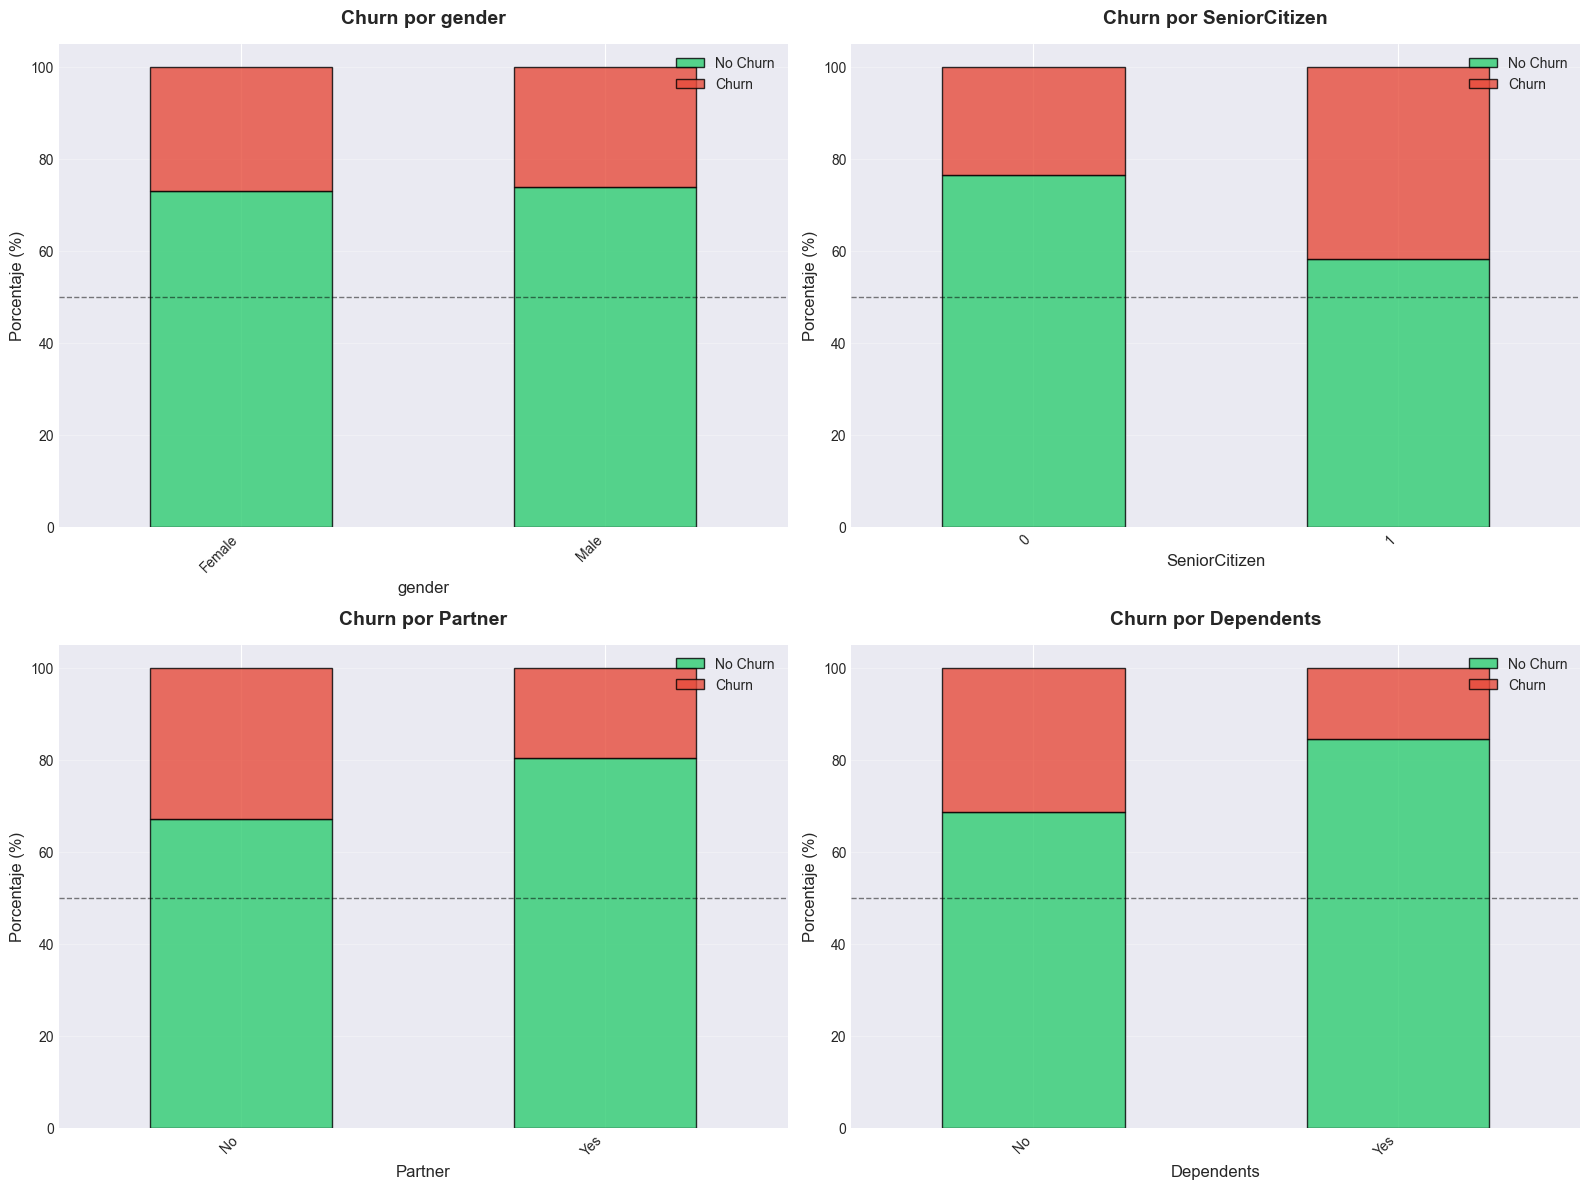


📊 Interpretación:
   - Las barras rojas son clientes que hicieron churn
   - Si una categoría tiene mucho rojo = alto riesgo de churn
   - La línea punteada marca el 50% (referencia)


In [4]:
# Variables demográficas
demographic_vars = ['gender', 'SeniorCitizen', 'Partner', 'Dependents']

# Crear subplots (múltiples gráficos en una figura)
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()  # Convertir matriz 2x2 en lista

for i, var in enumerate(demographic_vars):
    # Contar por categoría y Churn
    churn_data = df.groupby([var, 'Churn']).size().unstack(fill_value=0)
    
    # Calcular porcentajes
    churn_pct = churn_data.div(churn_data.sum(axis=1), axis=0) * 100
    
    # Crear gráfico de barras apiladas
    churn_pct.plot(kind='bar', stacked=True, ax=axes[i], 
                   color=['#2ecc71', '#e74c3c'], alpha=0.8, edgecolor='black')
    
    axes[i].set_title(f'Churn por {var}', fontsize=14, fontweight='bold', pad=15)
    axes[i].set_xlabel(var, fontsize=12)
    axes[i].set_ylabel('Porcentaje (%)', fontsize=12)
    axes[i].legend(['No Churn', 'Churn'], loc='upper right')
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right')
    axes[i].grid(axis='y', alpha=0.3)
    
    # Añadir línea horizontal en 50%
    axes[i].axhline(50, color='black', linestyle='--', linewidth=1, alpha=0.5)

plt.tight_layout()
plt.show()

print('\n📊 Interpretación:')
print('   - Las barras rojas son clientes que hicieron churn')
print('   - Si una categoría tiene mucho rojo = alto riesgo de churn')
print('   - La línea punteada marca el 50% (referencia)')

In [5]:
# Calcular tasas de churn exactas por variable demográfica
print('TASAS DE CHURN POR VARIABLE DEMOGRÁFICA')
print('=' * 70)

for var in demographic_vars:
    print(f'\n{var}:')
    print('-' * 50)
    
    churn_rate = df.groupby(var)['Churn'].apply(lambda x: (x == 'Yes').mean() * 100)
    counts = df[var].value_counts()
    
    for category in churn_rate.index:
        rate = churn_rate[category]
        count = counts[category]
        print(f'  {category:20} - {rate:5.1f}% churn  (n={count:,} clientes)')

print('\n' + '=' * 70)

TASAS DE CHURN POR VARIABLE DEMOGRÁFICA

gender:
--------------------------------------------------
  Female               -  26.9% churn  (n=3,488 clientes)
  Male                 -  26.2% churn  (n=3,555 clientes)

SeniorCitizen:
--------------------------------------------------
                     0 -  23.6% churn  (n=5,901 clientes)
                     1 -  41.7% churn  (n=1,142 clientes)

Partner:
--------------------------------------------------
  No                   -  33.0% churn  (n=3,641 clientes)
  Yes                  -  19.7% churn  (n=3,402 clientes)

Dependents:
--------------------------------------------------
  No                   -  31.3% churn  (n=4,933 clientes)
  Yes                  -  15.5% churn  (n=2,110 clientes)



## 📞 3. Análisis de Servicios Telefónicos

¿Los servicios telefónicos afectan el churn?

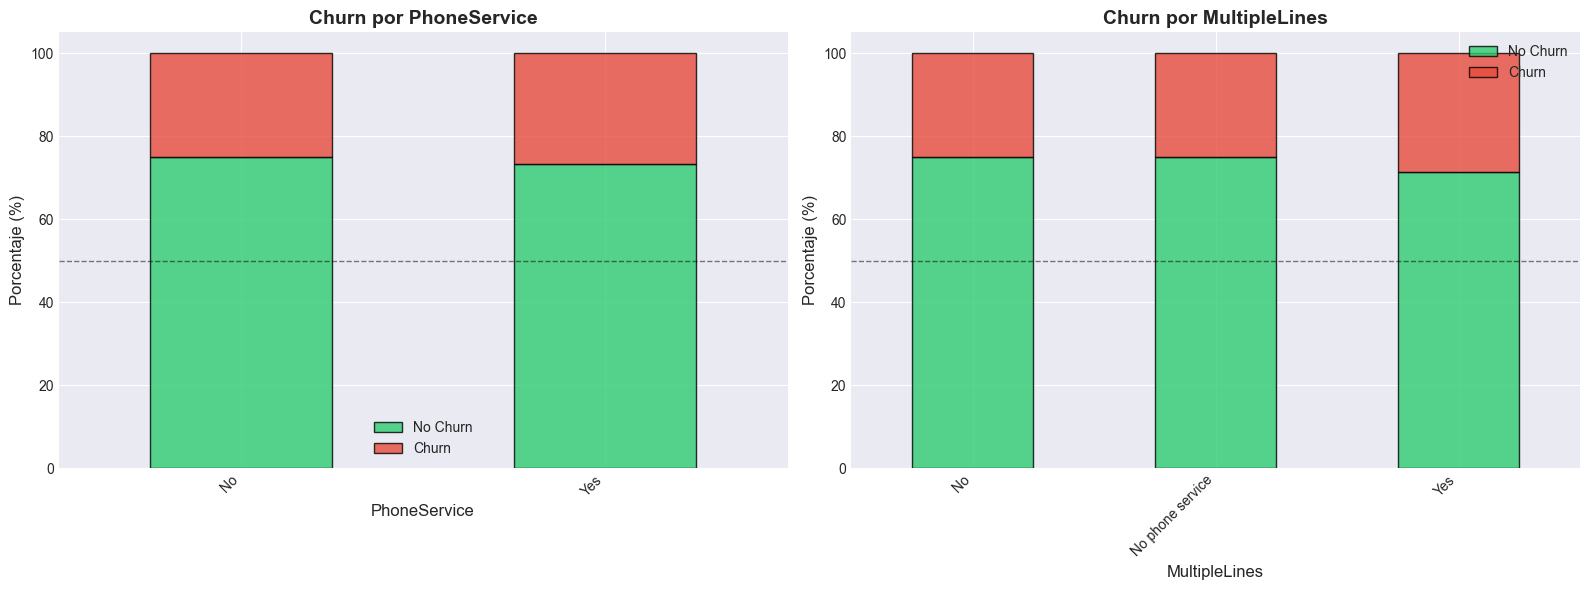

In [6]:
# Variables de servicios telefónicos
phone_vars = ['PhoneService', 'MultipleLines']

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for i, var in enumerate(phone_vars):
    churn_data = df.groupby([var, 'Churn']).size().unstack(fill_value=0)
    churn_pct = churn_data.div(churn_data.sum(axis=1), axis=0) * 100
    
    churn_pct.plot(kind='bar', stacked=True, ax=axes[i],
                   color=['#2ecc71', '#e74c3c'], alpha=0.8, edgecolor='black')
    
    axes[i].set_title(f'Churn por {var}', fontsize=14, fontweight='bold')
    axes[i].set_xlabel(var, fontsize=12)
    axes[i].set_ylabel('Porcentaje (%)', fontsize=12)
    axes[i].legend(['No Churn', 'Churn'])
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right')
    axes[i].axhline(50, color='black', linestyle='--', linewidth=1, alpha=0.5)

plt.tight_layout()
plt.show()

## 🌐 4. Análisis de Servicios de Internet

**Este es crítico** - Los servicios de internet suelen tener gran impacto en churn.

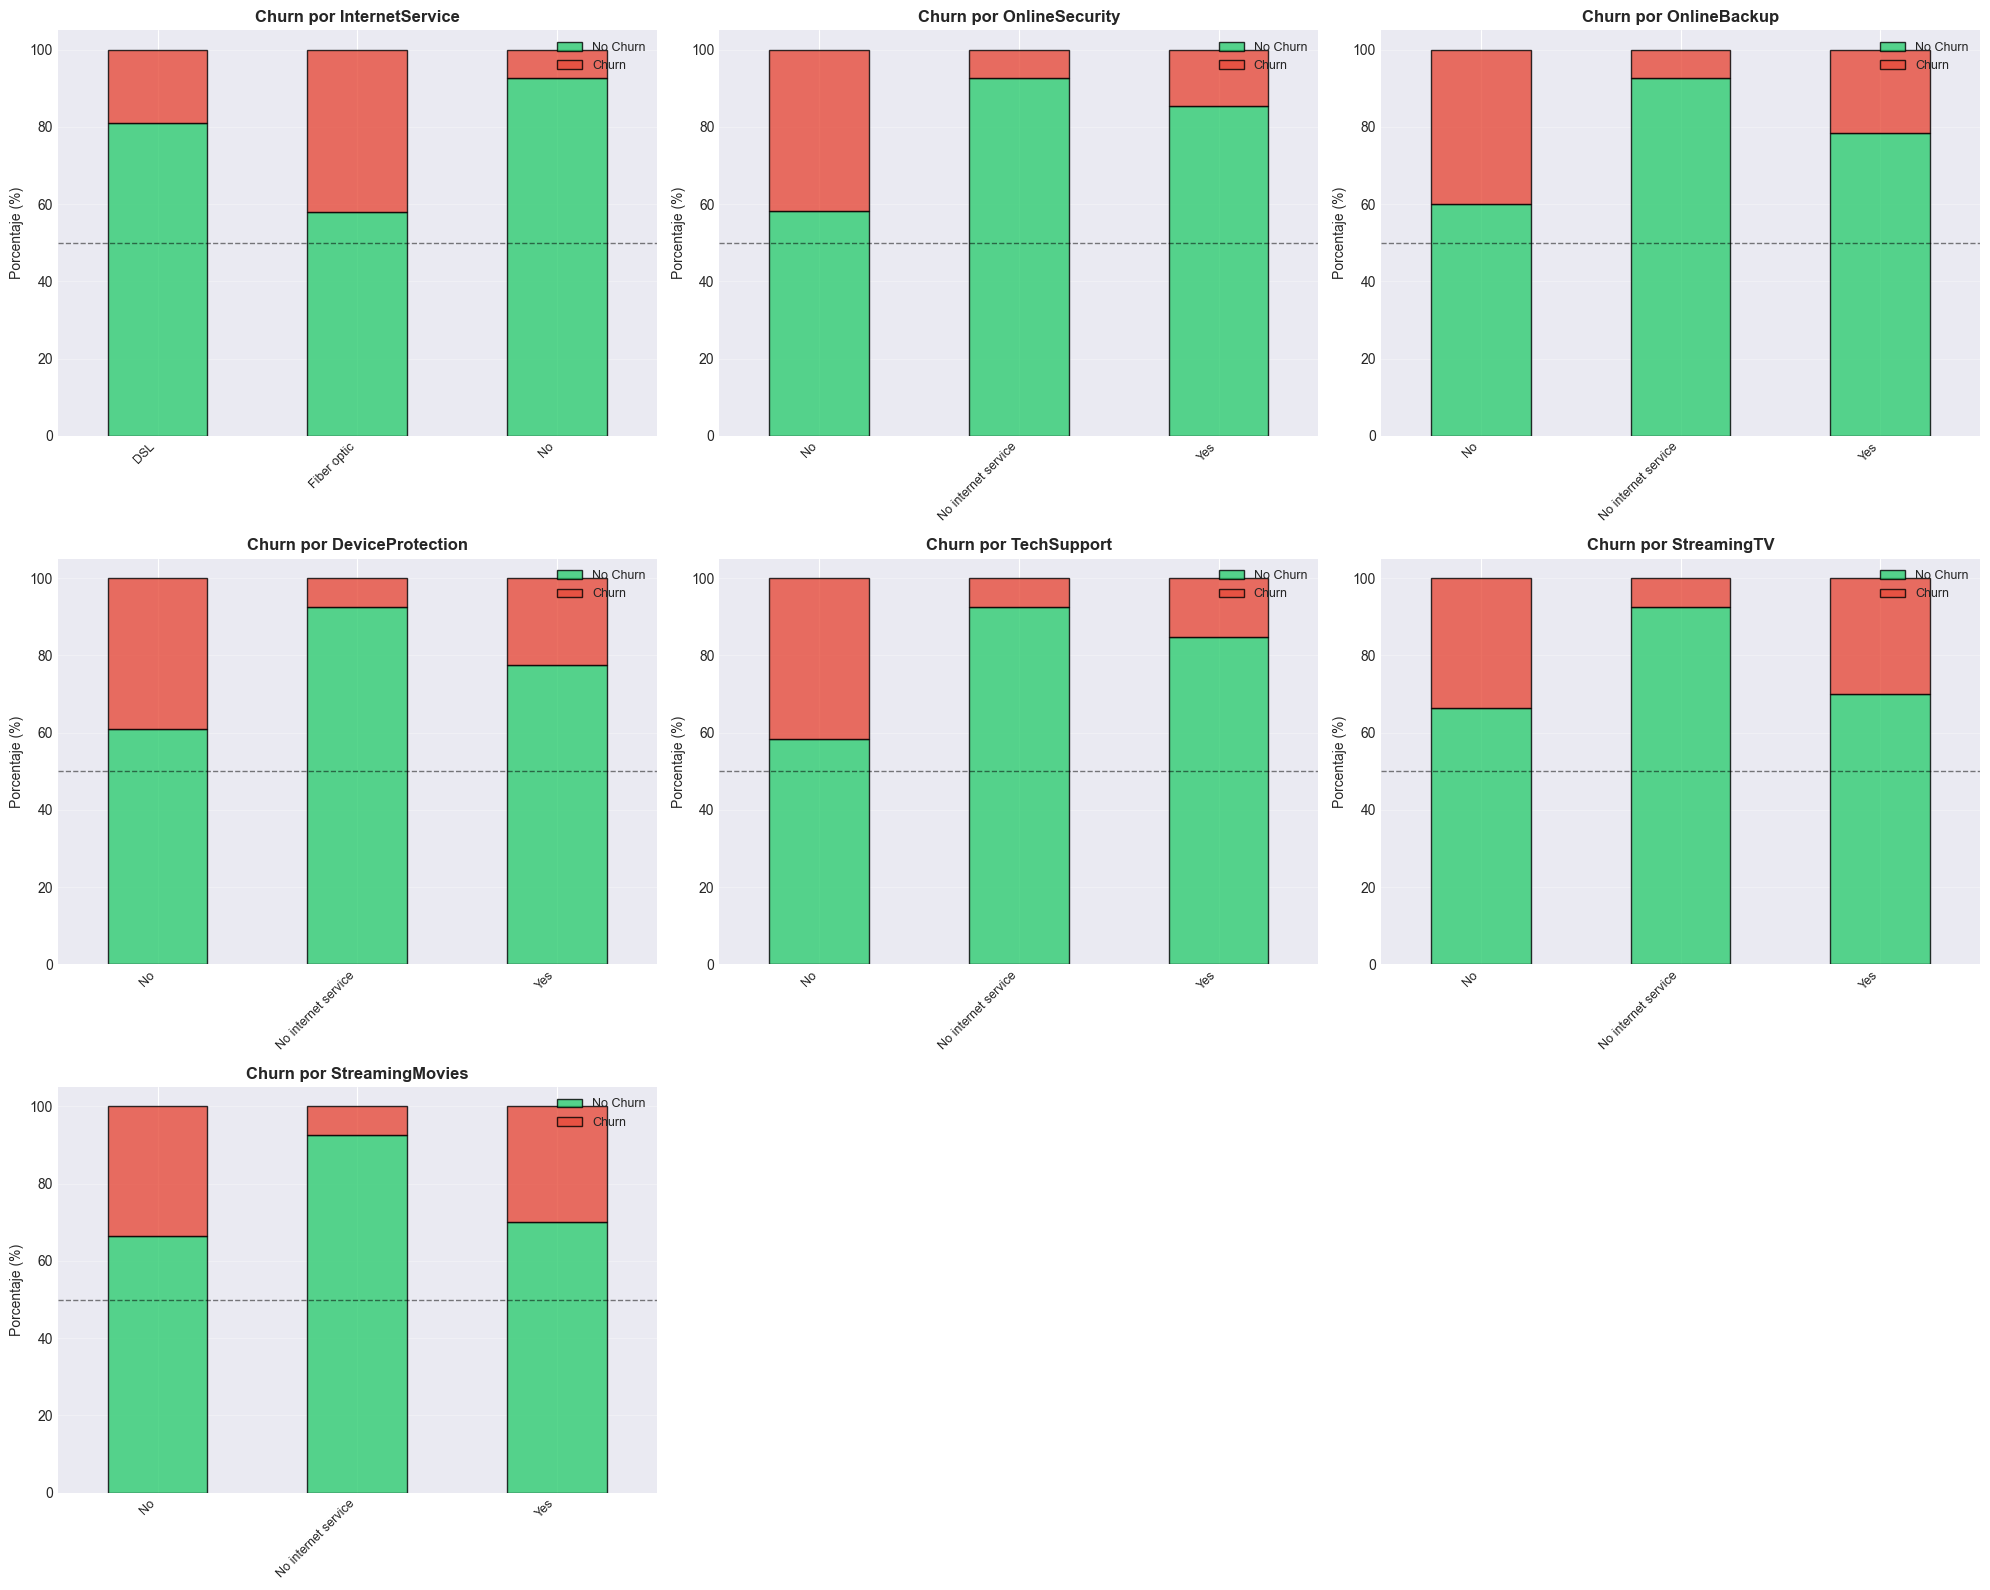


🔥 Insight Importante:
   Fíjate en las variables de seguridad (OnlineSecurity, TechSupport, etc.)
   ¿Los clientes SIN estos servicios tienen más churn?


In [7]:
# Variables de internet
internet_vars = ['InternetService', 'OnlineSecurity', 'OnlineBackup', 
                 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

# Crear grid de subplots
fig, axes = plt.subplots(3, 3, figsize=(20, 16))
axes = axes.ravel()

for i, var in enumerate(internet_vars):
    churn_data = df.groupby([var, 'Churn']).size().unstack(fill_value=0)
    churn_pct = churn_data.div(churn_data.sum(axis=1), axis=0) * 100
    
    churn_pct.plot(kind='bar', stacked=True, ax=axes[i],
                   color=['#2ecc71', '#e74c3c'], alpha=0.8, edgecolor='black')
    
    axes[i].set_title(f'Churn por {var}', fontsize=12, fontweight='bold')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Porcentaje (%)', fontsize=10)
    axes[i].legend(['No Churn', 'Churn'], loc='upper right', fontsize=9)
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right', fontsize=9)
    axes[i].axhline(50, color='black', linestyle='--', linewidth=1, alpha=0.5)
    axes[i].grid(axis='y', alpha=0.3)

# Ocultar subplots vacíos
for j in range(len(internet_vars), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

print('\n🔥 Insight Importante:')
print('   Fíjate en las variables de seguridad (OnlineSecurity, TechSupport, etc.)')
print('   ¿Los clientes SIN estos servicios tienen más churn?')

In [8]:
# Análisis detallado de servicios de internet
print('TASAS DE CHURN POR SERVICIOS DE INTERNET')
print('=' * 70)

for var in internet_vars:
    print(f'\n{var}:')
    print('-' * 50)
    
    churn_rate = df.groupby(var)['Churn'].apply(lambda x: (x == 'Yes').mean() * 100)
    churn_rate_sorted = churn_rate.sort_values(ascending=False)
    
    for category in churn_rate_sorted.index:
        rate = churn_rate_sorted[category]
        count = (df[var] == category).sum()
        risk = '🔴 ALTO' if rate > 35 else '🟡 MEDIO' if rate > 25 else '🟢 BAJO'
        print(f'  {category:25} - {rate:5.1f}% {risk:12} (n={count:,})')

print('\n' + '=' * 70)

TASAS DE CHURN POR SERVICIOS DE INTERNET

InternetService:
--------------------------------------------------
  Fiber optic               -  41.9% 🔴 ALTO       (n=3,096)
  DSL                       -  19.0% 🟢 BAJO       (n=2,421)
  No                        -   7.4% 🟢 BAJO       (n=1,526)

OnlineSecurity:
--------------------------------------------------
  No                        -  41.8% 🔴 ALTO       (n=3,498)
  Yes                       -  14.6% 🟢 BAJO       (n=2,019)
  No internet service       -   7.4% 🟢 BAJO       (n=1,526)

OnlineBackup:
--------------------------------------------------
  No                        -  39.9% 🔴 ALTO       (n=3,088)
  Yes                       -  21.5% 🟢 BAJO       (n=2,429)
  No internet service       -   7.4% 🟢 BAJO       (n=1,526)

DeviceProtection:
--------------------------------------------------
  No                        -  39.1% 🔴 ALTO       (n=3,095)
  Yes                       -  22.5% 🟢 BAJO       (n=2,422)
  No internet service     

## 💳 5. Análisis de Contrato y Facturación

**MUY IMPORTANTE:** El tipo de contrato suele ser uno de los predictores más fuertes de churn.

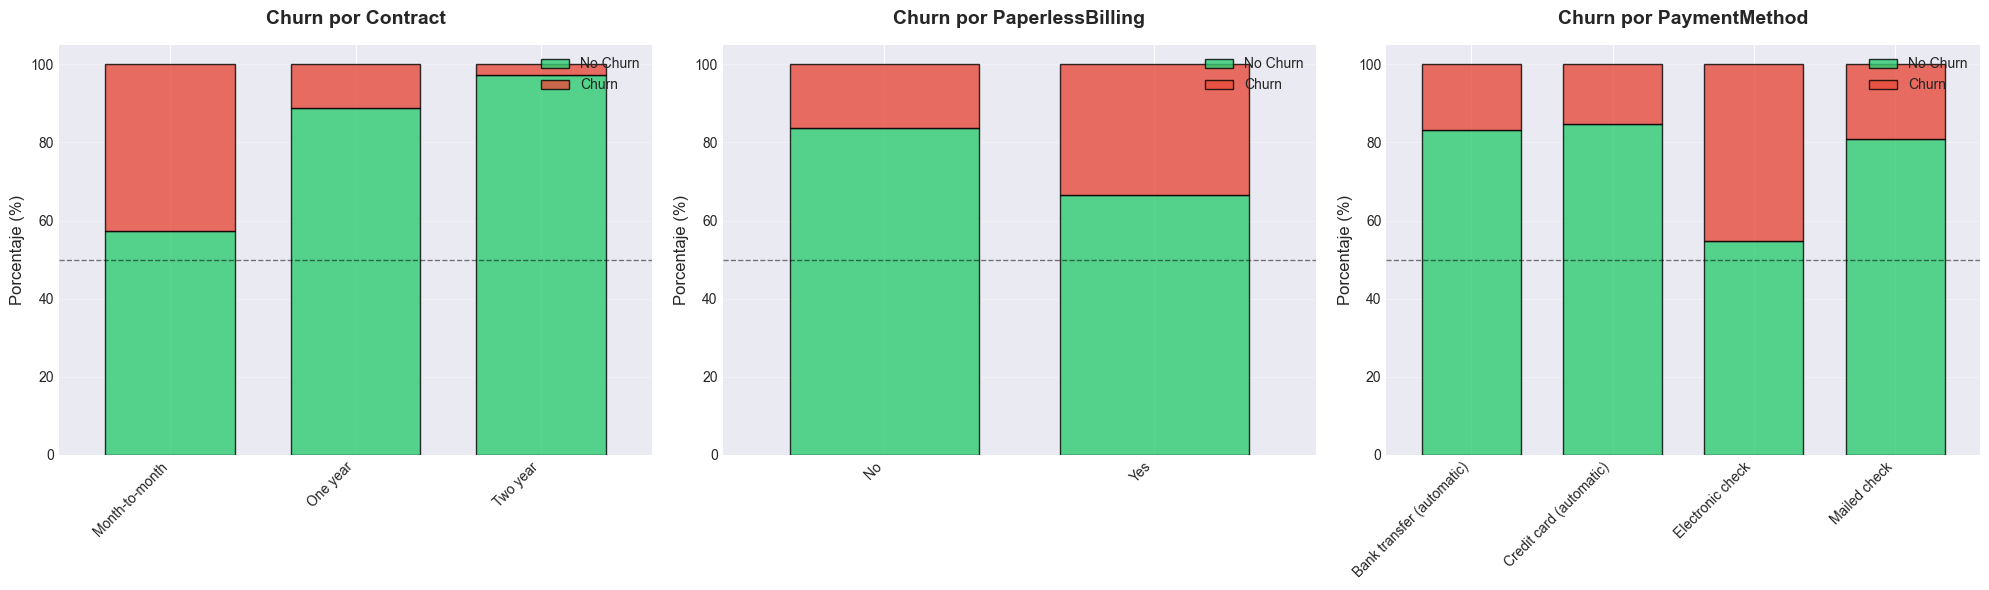


💡 Pregunta clave: ¿Qué tipo de contrato tiene MÁS churn?
   Pista: Esto nos dice mucho sobre el comportamiento del cliente


In [9]:
# Variables de contrato y pago
billing_vars = ['Contract', 'PaperlessBilling', 'PaymentMethod']

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for i, var in enumerate(billing_vars):
    churn_data = df.groupby([var, 'Churn']).size().unstack(fill_value=0)
    churn_pct = churn_data.div(churn_data.sum(axis=1), axis=0) * 100
    
    churn_pct.plot(kind='bar', stacked=True, ax=axes[i],
                   color=['#2ecc71', '#e74c3c'], alpha=0.8, edgecolor='black', width=0.7)
    
    axes[i].set_title(f'Churn por {var}', fontsize=14, fontweight='bold', pad=15)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Porcentaje (%)', fontsize=12)
    axes[i].legend(['No Churn', 'Churn'], loc='upper right')
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right')
    axes[i].axhline(50, color='black', linestyle='--', linewidth=1, alpha=0.5)
    axes[i].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print('\n💡 Pregunta clave: ¿Qué tipo de contrato tiene MÁS churn?')
print('   Pista: Esto nos dice mucho sobre el comportamiento del cliente')

In [10]:
# Tasas exactas
print('TASAS DE CHURN POR TIPO DE CONTRATO Y FACTURACIÓN')
print('=' * 70)

for var in billing_vars:
    print(f'\n{var}:')
    print('-' * 50)
    
    churn_rate = df.groupby(var)['Churn'].apply(lambda x: (x == 'Yes').mean() * 100)
    churn_rate_sorted = churn_rate.sort_values(ascending=False)
    
    for category in churn_rate_sorted.index:
        rate = churn_rate_sorted[category]
        count = (df[var] == category).sum()
        risk = '🔴 CRÍTICO' if rate > 40 else '🟡 MEDIO' if rate > 25 else '🟢 BAJO'
        print(f'  {category:30} - {rate:5.1f}% {risk:14} (n={count:,})')

print('\n' + '=' * 70)

TASAS DE CHURN POR TIPO DE CONTRATO Y FACTURACIÓN

Contract:
--------------------------------------------------
  Month-to-month                 -  42.7% 🔴 CRÍTICO      (n=3,875)
  One year                       -  11.3% 🟢 BAJO         (n=1,473)
  Two year                       -   2.8% 🟢 BAJO         (n=1,695)

PaperlessBilling:
--------------------------------------------------
  Yes                            -  33.6% 🟡 MEDIO        (n=4,171)
  No                             -  16.3% 🟢 BAJO         (n=2,872)

PaymentMethod:
--------------------------------------------------
  Electronic check               -  45.3% 🔴 CRÍTICO      (n=2,365)
  Mailed check                   -  19.1% 🟢 BAJO         (n=1,612)
  Bank transfer (automatic)      -  16.7% 🟢 BAJO         (n=1,544)
  Credit card (automatic)        -  15.2% 🟢 BAJO         (n=1,522)



## 🎯 6. Ranking de Variables por Impacto en Churn

Vamos a calcular qué variables tienen la mayor diferencia en tasas de churn.

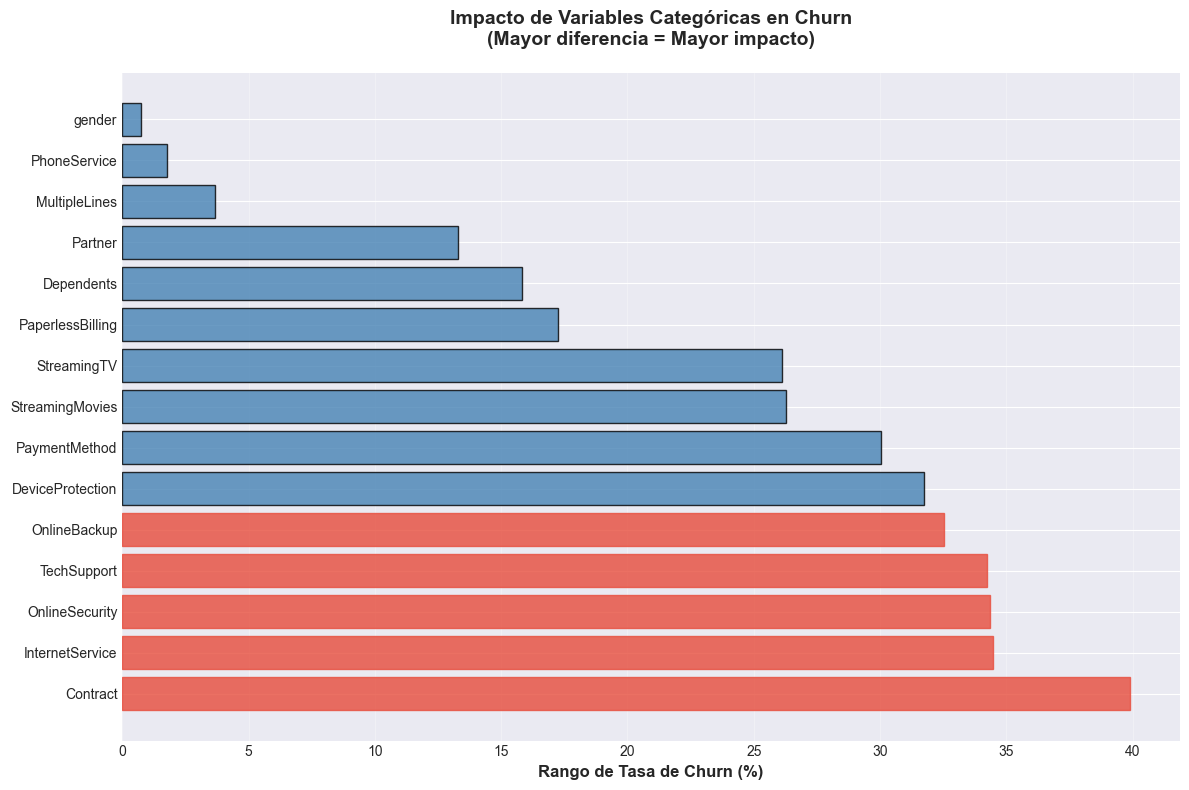


🏆 TOP 5 VARIABLES MÁS IMPORTANTES:
Contract                  - Impacto: 39.9%
InternetService           - Impacto: 34.5%
OnlineSecurity            - Impacto: 34.4%
TechSupport               - Impacto: 34.2%
OnlineBackup              - Impacto: 32.5%

💡 Estas variables serán muy importantes para nuestro modelo de ML


In [11]:
# Calcular el rango (diferencia entre max y min) de tasa de churn para cada variable
impact_scores = {}

for col in categorical_cols:
    churn_rates = df.groupby(col)['Churn'].apply(lambda x: (x == 'Yes').mean() * 100)
    impact = churn_rates.max() - churn_rates.min()
    impact_scores[col] = impact

# Convertir a DataFrame y ordenar
impact_df = pd.DataFrame(list(impact_scores.items()), columns=['Variable', 'Impacto'])
impact_df = impact_df.sort_values('Impacto', ascending=False)

# Visualizar
plt.figure(figsize=(12, 8))
bars = plt.barh(impact_df['Variable'], impact_df['Impacto'], 
                color='steelblue', alpha=0.8, edgecolor='black')

# Colorear las top 5 de rojo
for i in range(min(5, len(bars))):
    bars[i].set_color('#e74c3c')
    bars[i].set_alpha(0.8)

plt.xlabel('Rango de Tasa de Churn (%)', fontsize=12, fontweight='bold')
plt.title('Impacto de Variables Categóricas en Churn\n(Mayor diferencia = Mayor impacto)', 
          fontsize=14, fontweight='bold', pad=20)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print('\n🏆 TOP 5 VARIABLES MÁS IMPORTANTES:')
print('=' * 60)
for i, row in impact_df.head(5).iterrows():
    print(f'{row["Variable"]:25} - Impacto: {row["Impacto"]:.1f}%')
print('\n💡 Estas variables serán muy importantes para nuestro modelo de ML')

## 🔥 7. Visualización Avanzada: Heatmap de Churn

Vamos a crear un mapa de calor que muestre la tasa de churn para cada categoría.

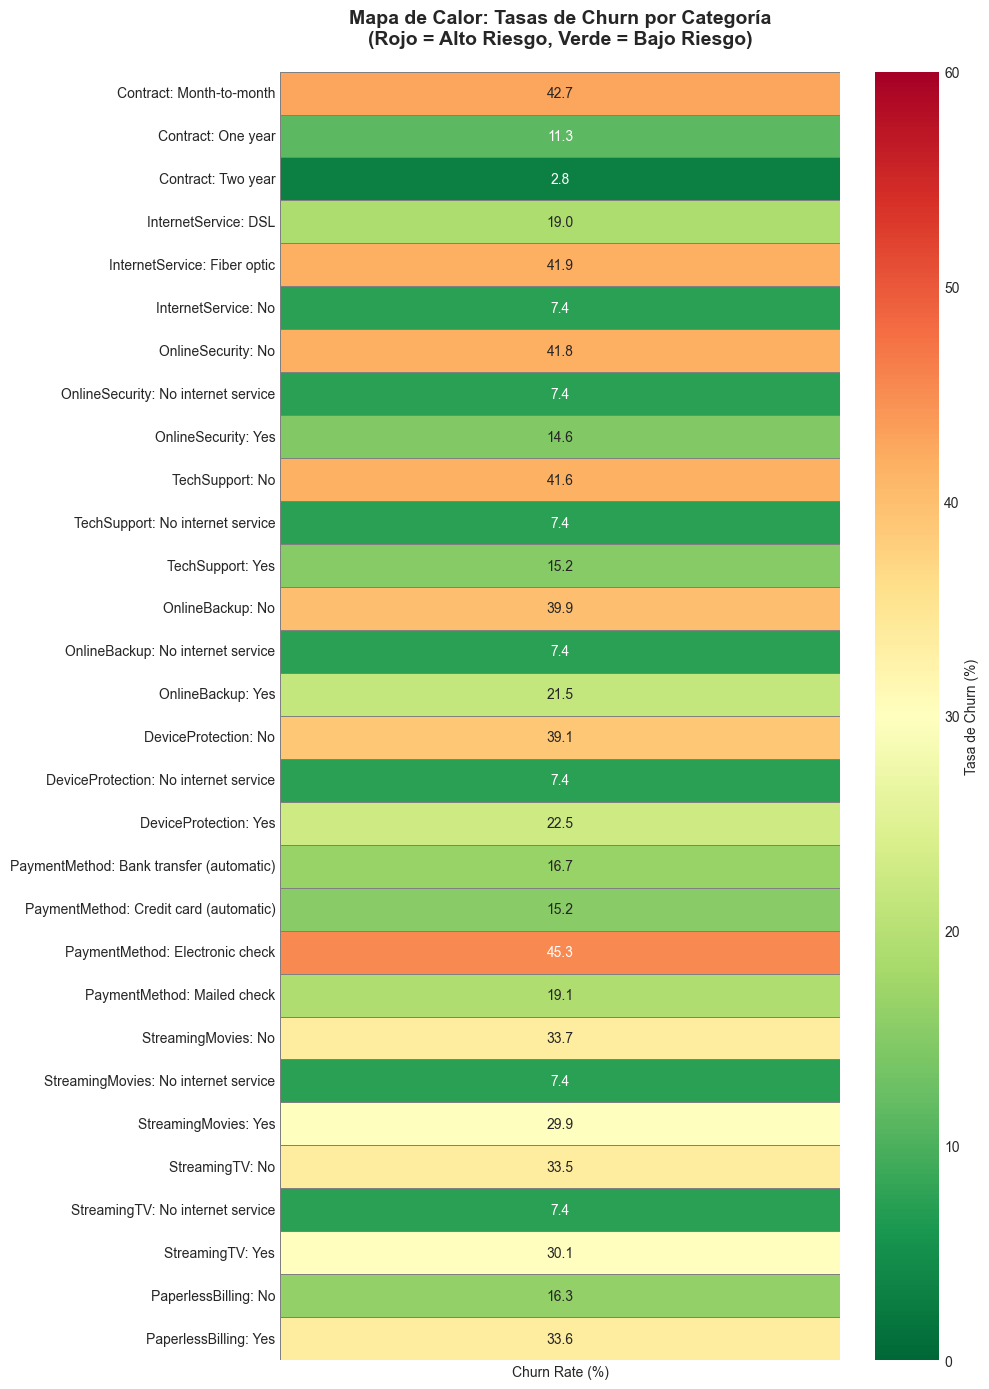


🎨 Interpretación del mapa de calor:
   🔴 Rojo/Naranja: Tasa de churn alta (>40%) - ALTO RIESGO
   🟡 Amarillo: Tasa de churn media (25-40%) - RIESGO MODERADO
   🟢 Verde: Tasa de churn baja (<25%) - BAJO RIESGO


In [12]:
# Crear matriz de tasas de churn
# Seleccionar las top 10 variables más importantes
top_vars = impact_df.head(10)['Variable'].tolist()

churn_matrix = []
labels = []

for var in top_vars:
    rates = df.groupby(var)['Churn'].apply(lambda x: (x == 'Yes').mean() * 100)
    for category, rate in rates.items():
        churn_matrix.append([rate])
        labels.append(f'{var}: {category}')

# Crear heatmap
plt.figure(figsize=(10, 14))
sns.heatmap(churn_matrix, annot=True, fmt='.1f', cmap='RdYlGn_r',
            yticklabels=labels, xticklabels=['Churn Rate (%)'],
            cbar_kws={'label': 'Tasa de Churn (%)'},
            linewidths=0.5, linecolor='gray',
            vmin=0, vmax=60)

plt.title('Mapa de Calor: Tasas de Churn por Categoría\n(Rojo = Alto Riesgo, Verde = Bajo Riesgo)',
          fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print('\n🎨 Interpretación del mapa de calor:')
print('   🔴 Rojo/Naranja: Tasa de churn alta (>40%) - ALTO RIESGO')
print('   🟡 Amarillo: Tasa de churn media (25-40%) - RIESGO MODERADO')
print('   🟢 Verde: Tasa de churn baja (<25%) - BAJO RIESGO')

## 📊 8. Análisis Combinado: Múltiples Variables

¿Qué pasa cuando combinamos variables? Por ejemplo: Contract + InternetService

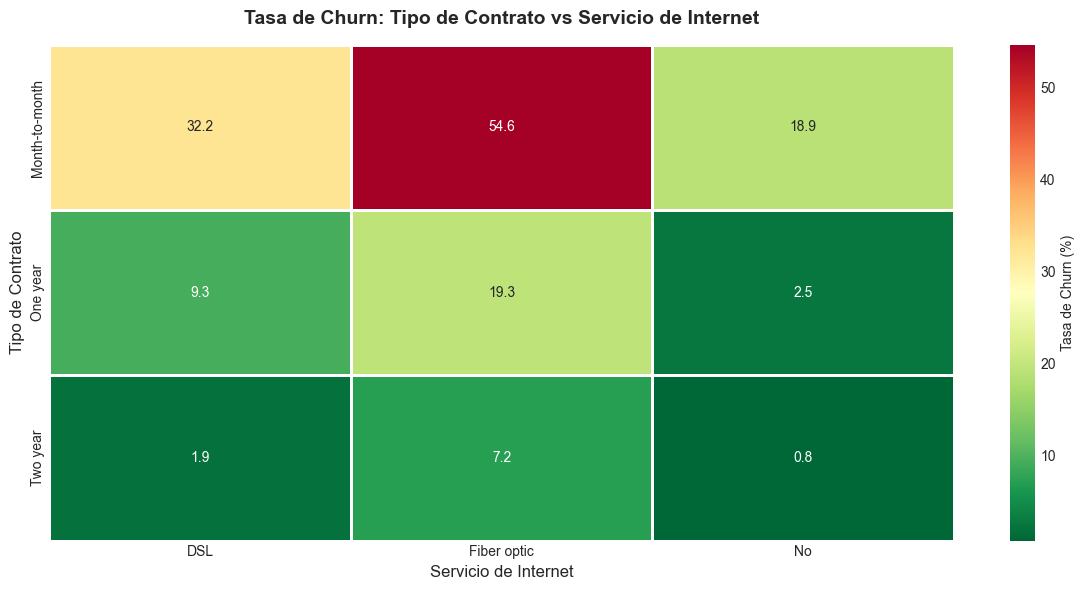


💡 Observa:
   - ¿Qué combinación tiene la MAYOR tasa de churn?
   - ¿Qué combinación tiene la MENOR tasa de churn?
   - Esto nos ayuda a identificar perfiles de alto riesgo


In [13]:
# Análisis de Contract x InternetService
combined = df.groupby(['Contract', 'InternetService', 'Churn']).size().unstack(fill_value=0)
combined_pct = combined.div(combined.sum(axis=1), axis=0) * 100

# Extraer solo la columna 'Yes' (churn)
churn_combined = combined_pct['Yes'].unstack()

plt.figure(figsize=(12, 6))
sns.heatmap(churn_combined, annot=True, fmt='.1f', cmap='RdYlGn_r',
            linewidths=1, linecolor='white', cbar_kws={'label': 'Tasa de Churn (%)'})
plt.title('Tasa de Churn: Tipo de Contrato vs Servicio de Internet', 
          fontsize=14, fontweight='bold', pad=15)
plt.xlabel('Servicio de Internet', fontsize=12)
plt.ylabel('Tipo de Contrato', fontsize=12)
plt.tight_layout()
plt.show()

print('\n💡 Observa:')
print('   - ¿Qué combinación tiene la MAYOR tasa de churn?')
print('   - ¿Qué combinación tiene la MENOR tasa de churn?')
print('   - Esto nos ayuda a identificar perfiles de alto riesgo')

## 🎯 9. Perfil del Cliente de Alto Riesgo

Con todo lo que aprendimos, creemos el perfil típico de un cliente con alto riesgo de churn.

In [14]:
# Identificar características del perfil de alto riesgo
churn_yes = df[df['Churn'] == 'Yes']

print('=' * 70)
print('PERFIL DEL CLIENTE CON ALTO RIESGO DE CHURN')
print('=' * 70)

print('\n📊 CARACTERÍSTICAS DEMOGRÁFICAS:')
print(f"  • Género más frecuente: {churn_yes['gender'].mode()[0]}")
print(f"  • ¿Senior?: {churn_yes['SeniorCitizen'].mode()[0]} (0=No, 1=Sí)")
print(f"  • ¿Tiene pareja?: {churn_yes['Partner'].mode()[0]}")
print(f"  • ¿Tiene dependientes?: {churn_yes['Dependents'].mode()[0]}")

print('\n💰 COMPORTAMIENTO FINANCIERO:')
print(f"  • Tenure promedio: {churn_yes['tenure'].mean():.1f} meses (¡Bajo!)")
print(f"  • Cargo mensual promedio: ${churn_yes['MonthlyCharges'].mean():.2f}")
print(f"  • Tipo de contrato más común: {churn_yes['Contract'].mode()[0]}")
print(f"  • Método de pago más común: {churn_yes['PaymentMethod'].mode()[0]}")

print('\n🌐 SERVICIOS CONTRATADOS:')
print(f"  • Servicio de internet: {churn_yes['InternetService'].mode()[0]}")
print(f"  • Online Security: {churn_yes['OnlineSecurity'].mode()[0]}")
print(f"  • Tech Support: {churn_yes['TechSupport'].mode()[0]}")

print('\n' + '=' * 70)
print('\n🎯 CONCLUSIÓN:')
print('   El cliente típico de alto riesgo es alguien que:')
print('   1. Es nuevo (pocos meses como cliente)')
print('   2. Tiene contrato mes a mes (sin compromiso largo)')
print('   3. No tiene servicios de protección/soporte adicionales')
print('   4. Usa métodos de pago automáticos como Electronic check')
print('\n   📈 ACCIÓN: Enfocarse en retener clientes nuevos con promociones!')

PERFIL DEL CLIENTE CON ALTO RIESGO DE CHURN

📊 CARACTERÍSTICAS DEMOGRÁFICAS:
  • Género más frecuente: Female
  • ¿Senior?: 0 (0=No, 1=Sí)
  • ¿Tiene pareja?: No
  • ¿Tiene dependientes?: No

💰 COMPORTAMIENTO FINANCIERO:
  • Tenure promedio: 18.0 meses (¡Bajo!)
  • Cargo mensual promedio: $74.44
  • Tipo de contrato más común: Month-to-month
  • Método de pago más común: Electronic check

🌐 SERVICIOS CONTRATADOS:
  • Servicio de internet: Fiber optic
  • Online Security: No
  • Tech Support: No


🎯 CONCLUSIÓN:
   El cliente típico de alto riesgo es alguien que:
   1. Es nuevo (pocos meses como cliente)
   2. Tiene contrato mes a mes (sin compromiso largo)
   3. No tiene servicios de protección/soporte adicionales
   4. Usa métodos de pago automáticos como Electronic check

   📈 ACCIÓN: Enfocarse en retener clientes nuevos con promociones!


## 📝 10. Resumen de Insights Clave

Documentemos todos los hallazgos importantes.

In [15]:
print('=' * 80)
print('RESUMEN: ANÁLISIS DE VARIABLES CATEGÓRICAS')
print('=' * 80)

print('\n🏆 TOP 5 FACTORES DE RIESGO MÁS IMPORTANTES:')
for i, row in impact_df.head(5).iterrows():
    print(f'   {impact_df.index.tolist().index(i)+1}. {row["Variable"]:25} (Impacto: {row["Impacto"]:.1f}%)')

print('\n🔴 SEÑALES DE ALERTA (Alto Riesgo de Churn):')
print('   ✗ Contrato Month-to-month')
print('   ✗ Sin servicios de seguridad (OnlineSecurity, TechSupport)')
print('   ✗ Tenure bajo (<12 meses)')
print('   ✗ Fiber optic sin protecciones adicionales')
print('   ✗ Pago con Electronic check')

print('\n🟢 SEÑALES POSITIVAS (Bajo Riesgo de Churn):')
print('   ✓ Contrato de 1 o 2 años')
print('   ✓ Servicios adicionales contratados')
print('   ✓ Tenure alto (>24 meses)')
print('   ✓ Tiene pareja y/o dependientes')

print('\n💡 RECOMENDACIONES PARA EL NEGOCIO:')
print('   1. Ofrecer descuentos en contratos anuales')
print('   2. Incluir OnlineSecurity y TechSupport en paquetes base')
print('   3. Programa especial de retención para nuevos clientes (<6 meses)')
print('   4. Incentivos para cambiar de Month-to-month a contratos largos')

print('\n🎯 PRÓXIMOS PASOS:')
print('   1. Feature Engineering: Crear nuevas variables combinadas')
print('   2. Preparar datos para Machine Learning')
print('   3. Entrenar modelos predictivos')

print('\n' + '=' * 80)

RESUMEN: ANÁLISIS DE VARIABLES CATEGÓRICAS

🏆 TOP 5 FACTORES DE RIESGO MÁS IMPORTANTES:
   1. Contract                  (Impacto: 39.9%)
   2. InternetService           (Impacto: 34.5%)
   3. OnlineSecurity            (Impacto: 34.4%)
   4. TechSupport               (Impacto: 34.2%)
   5. OnlineBackup              (Impacto: 32.5%)

🔴 SEÑALES DE ALERTA (Alto Riesgo de Churn):
   ✗ Contrato Month-to-month
   ✗ Sin servicios de seguridad (OnlineSecurity, TechSupport)
   ✗ Tenure bajo (<12 meses)
   ✗ Fiber optic sin protecciones adicionales
   ✗ Pago con Electronic check

🟢 SEÑALES POSITIVAS (Bajo Riesgo de Churn):
   ✓ Contrato de 1 o 2 años
   ✓ Servicios adicionales contratados
   ✓ Tenure alto (>24 meses)
   ✓ Tiene pareja y/o dependientes

💡 RECOMENDACIONES PARA EL NEGOCIO:
   1. Ofrecer descuentos en contratos anuales
   2. Incluir OnlineSecurity y TechSupport en paquetes base
   3. Programa especial de retención para nuevos clientes (<6 meses)
   4. Incentivos para cambiar de Month

## 🎓 Conceptos Aprendidos

✅ **Análisis de variables categóricas**  
✅ **Gráficos de barras apiladas** para comparar grupos  
✅ **Cálculo de tasas de churn** por categoría  
✅ **Heatmaps** para visualizar patrones  
✅ **Análisis combinado** de múltiples variables  
✅ **Identificación de perfiles de riesgo**  
✅ **Ranking de importancia** de features  

---

## ⏭️ Siguiente Paso

En el próximo notebook empezaremos con **Feature Engineering**: crear nuevas variables que ayuden al modelo a predecir mejor.

**¡Guarda este notebook y haz commit!**